# Segmentation: K-means

## Import Libraries and starting PySpark


In [48]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import CountVectorizer, PCA, StopWordsRemover, RegexTokenizer, Word2Vec, Normalizer
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.sql.functions import explode, desc, count, row_number, when, col
from pathlib import Path
import pandas 

In [ ]:
CUR = Path("../data/curated")

In [50]:
# Create a spark session
spark = (
    SparkSession.builder.appName("Kmeans Ranking Segmentation")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "9g") 
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.network.timeout", "600s")
    .getOrCreate()
)

## Load data

In [ ]:
merchant = spark.read.parquet(str("../data/curated/merchant_features.parquet"))


In [52]:
merchant.count()

4026

In [53]:
merchant.printSchema()

root
 |-- merchant_abn: string (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- type: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- order_count: long (nullable = true)
 |-- total_sales: double (nullable = true)
 |-- avg_order_value: double (nullable = true)
 |-- unique_consumers: long (nullable = true)
 |-- repeat_consumers: long (nullable = true)
 |-- repurchase_rate: double (nullable = true)



In [54]:
# Getting all the segments
categories = merchant.select("categories")
categories.show(truncate=False)

+---------------------------------------------------------------------------------------+
|categories                                                                             |
+---------------------------------------------------------------------------------------+
|[furniture, home furnishings and equipment shops, and manufacturers, except appliances]|
|[cable, satellite, and other pay television and radio services]                        |
|[jewelry, watch, clock, and silverware shops]                                          |
|[watch, clock, and jewelry repair shops]                                               |
|[music shops - musical instruments, pianos, and sheet music]                           |
|[gift, card, novelty, and souvenir shops]                                              |
|[computers, computer peripheral equipment, and software]                               |
|[watch, clock, and jewelry repair shops]                                               |
|[computer

## Text cleaning and preprocessing

In [55]:
# Join array into one string per row 
categories_str = categories.withColumn("categories_str", F.concat_ws(" ", F.col("categories")))

# Split strings into words and explode into separate rows
categories_words = categories_str.withColumn(
    "word",
    F.explode(F.split((F.col("categories_str")), r"\s+"))
)

# Remove empty strings
categories_words = categories_words.filter(F.col("word") != "")

# Count frequencies
word_counts = categories_words.groupBy("word").count().orderBy(F.desc("count"))

# Show top 100 most common words to become additional_stopwords
word_counts.show(100,truncate=False)

+-------------+-----+
|word         |count|
+-------------+-----+
|and          |4173 |
|shops        |1789 |
|music        |529  |
|equipment    |497  |
|services     |495  |
|supplies     |492  |
|-            |466  |
|computer     |372  |
|books        |359  |
|supply       |346  |
|furniture    |316  |
|sales        |299  |
|jewelry      |261  |
|watch        |261  |
|clock        |261  |
|goods:       |195  |
|digital      |195  |
|movies       |195  |
|craft        |193  |
|artist       |193  |
|integrated   |191  |
|programming  |191  |
|data         |191  |
|systems      |191  |
|processing   |191  |
|design       |191  |
|shoe         |185  |
|souvenir     |182  |
|novelty      |182  |
|manufacturers|182  |
|appliances   |182  |
|except       |182  |
|furnishings  |182  |
|card         |182  |
|gift         |182  |
|home         |182  |
|computers    |181  |
|software     |181  |
|peripheral   |181  |
|flowers      |180  |
|stock        |180  |
|florists     |180  |
|nursery  

Remove words that appear to frequent or too generic

In [56]:
# Tokenize segments
tokenizer = RegexTokenizer(inputCol="categories_str", outputCol="tokens", pattern="[^a-zA-Z0-9]+", gaps=True)
clean_categories = tokenizer.transform(categories_str)

# Stop words removal
default_stopwords = StopWordsRemover.loadDefaultStopWords("english")
additional_stopwords = ["and", "shops", "-", "services", "supplies", "equipment", "sales",
                        "repair", "goods","repairs", "music"]
total_stopwords = default_stopwords + additional_stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="clean_categories", stopWords=total_stopwords)
clean_categories = remover.transform(clean_categories)

# Clean categories
clean_categories = clean_categories.select('clean_categories')
clean_categories.show(1000, truncate=False)

+----------------------------------------------------------------------+
|clean_categories                                                      |
+----------------------------------------------------------------------+
|[furniture, home, furnishings, manufacturers, except, appliances]     |
|[cable, satellite, pay, television, radio]                            |
|[jewelry, watch, clock, silverware]                                   |
|[watch, clock, jewelry]                                               |
|[musical, instruments, pianos, sheet]                                 |
|[gift, card, novelty, souvenir]                                       |
|[computers, computer, peripheral, software]                           |
|[watch, clock, jewelry]                                               |
|[computer, programming, data, processing, integrated, systems, design]|
|[furniture, home, furnishings, manufacturers, except, appliances]     |
|[computers, computer, peripheral, software]       

In [57]:
# Align merchant df and cleaned categories df by adding index columns
merchant_index = merchant.withColumn("index", monotonically_increasing_id())
categories_index = clean_categories.withColumn("index", monotonically_increasing_id())
df_combined = merchant_index.join(categories_index, on="index", how="inner").drop("index")
df_combined.show(truncate=False)


+------------+------------------------------------+-----------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+----+---------+-----------+------------------+------------------+----------------+----------------+---------------------+----------------------------------------------------------------------+
|merchant_abn|name                                |tags                                                                                                             |categories                                                                             |type|take_rate|order_count|total_sales       |avg_order_value   |unique_consumers|repeat_consumers|repurchase_rate      |clean_categories                                                      |
+------------+------------------------------------+---------------------------------------------------------

## Embeddings

In [58]:
# Word2Vec
word2vec = Word2Vec(vectorSize=10, inputCol="clean_categories", outputCol="clean_categories_word2vec")

# Train the Word2Vec model
model = word2vec.fit(df_combined)

# Transform categories to get word vectors
df_word2vec = model.transform(df_combined)

# Show the resulting DataFrame with word vectors
df_word2vec.select("merchant_abn","clean_categories", "clean_categories_word2vec").show(truncate=False)

+------------+----------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|merchant_abn|clean_categories                                                      |clean_categories_word2vec                                                                                                                                                                                |
+------------+----------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10023283211 |[furniture, home, furnishings, manufacturers, except, appliances]     |[0.45513984809319175,-0.6843305826187134,1.83748747

## K-means Clustering

In [59]:
# Normalize vectors
df_w2v_norm = Normalizer(inputCol="clean_categories_word2vec",
                         outputCol="categories_norm",
                         p=2.0).transform(df_word2vec)


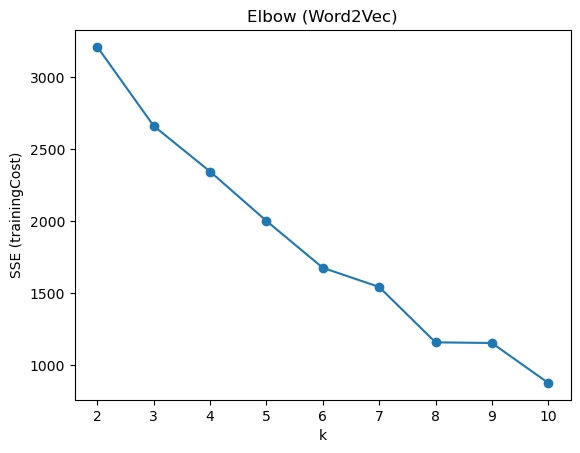

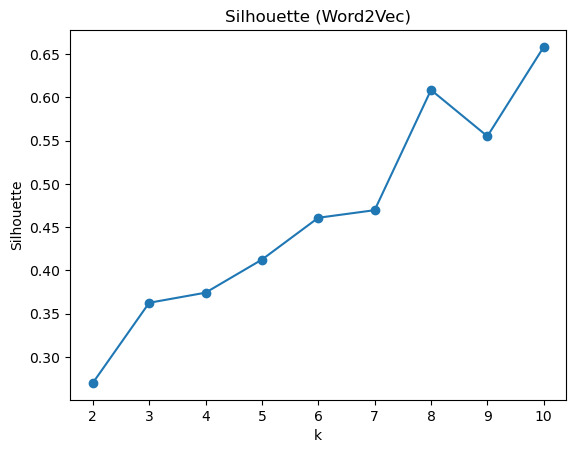

In [60]:
# Elbow and Silhouette methods to determine optimal k
ks = list(range(2, 11))
sse, sil = [], []
evaluator = ClusteringEvaluator(featuresCol="categories_norm", predictionCol="segment_id", metricName="silhouette")

for k in ks:
    km = KMeans(k=k, seed=42, featuresCol="categories_norm", predictionCol="segment_id")
    model = km.fit(df_w2v_norm)
    out = model.transform(df_w2v_norm)
    sse.append(model.summary.trainingCost)
    sil.append(evaluator.evaluate(out))

# Plot SSE vs k
plt.figure()
plt.plot(ks, sse, marker="o")
plt.xlabel("k"); plt.ylabel("SSE (trainingCost)"); plt.title("Elbow (Word2Vec)")
plt.show()

# Plot Silhouette vs k
plt.figure()
plt.plot(ks, sil, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.title("Silhouette (Word2Vec)")
plt.show()


In [61]:
# k = 8 from the elbow and silhouette plots
kmeans = KMeans(k=8, seed=42, featuresCol="categories_norm", predictionCol="segment_id")
km_model = kmeans.fit(df_w2v_norm)
clustered_df = km_model.transform(df_w2v_norm)
clustered_df.select("merchant_abn", "clean_categories", "segment_id").show(100, truncate=False)


+------------+----------------------------------------------------------------------+----------+
|merchant_abn|clean_categories                                                      |segment_id|
+------------+----------------------------------------------------------------------+----------+
|10023283211 |[furniture, home, furnishings, manufacturers, except, appliances]     |2         |
|10142254217 |[cable, satellite, pay, television, radio]                            |4         |
|10165489824 |[jewelry, watch, clock, silverware]                                   |3         |
|10187291046 |[watch, clock, jewelry]                                               |3         |
|10192359162 |[musical, instruments, pianos, sheet]                                 |4         |
|10206519221 |[gift, card, novelty, souvenir]                                       |1         |
|10255988167 |[computers, computer, peripheral, software]                           |1         |
|10264435225 |[watch, clock, j

In [62]:
# Explode categories into individual entries
exploded_df = clustered_df.withColumn("clean_categories", explode(col("clean_categories")))
grouped_df = exploded_df.groupBy("segment_id", "clean_categories").count()

# Rank categories within each segment
window = Window.partitionBy("segment_id").orderBy(desc("count"))
ranked = grouped_df.withColumn("rank", row_number().over(window))

# Keep top category per segment
most_common_category = ranked.filter(col("rank") == 1).drop("rank")
most_common_category.select("segment_id", "clean_categories", "count").show(truncate=False)

# Count merchants per segment
segment_count = clustered_df.groupBy("segment_id").agg(count("*").alias("merchant_count"))
segment_count.show(truncate=False)

+----------+----------------+-----+
|segment_id|clean_categories|count|
+----------+----------------+-----+
|0         |supply          |346  |
|1         |computer        |372  |
|2         |furniture       |316  |
|3         |watch           |261  |
|4         |shoe            |185  |
|5         |books           |359  |
|6         |flowers         |180  |
|7         |motor           |151  |
+----------+----------------+-----+

+----------+--------------+
|segment_id|merchant_count|
+----------+--------------+
|1         |554           |
|6         |505           |
|3         |627           |
|5         |537           |
|4         |839           |
|7         |302           |
|2         |316           |
|0         |346           |
+----------+--------------+



In [63]:
# Map each segment_id to a descriptive label (same with segmentation_manual)
segmented_df = clustered_df.withColumn(
    "segment",
    when(col("segment_id") == 0, "Miscellaneous") \
    .when(col("segment_id") == 1, "Technology") \
    .when(col("segment_id") == 2, "Office & Home Supplies") \
    .when(col("segment_id") == 3, "Beauty") \
    .when(col("segment_id") == 4, "Office & Home Supplies") \
    .when(col("segment_id") == 5, "Entertainment & Media") \
    .when(col("segment_id") == 6, "Beauty") \
    .when(col("segment_id") == 7, "Entertainment & Media") \
    .otherwise("Miscellaneous")
)
segmented_df.select("merchant_abn", "clean_categories", "segment_id", "segment").show(50, truncate=False)


+------------+----------------------------------------------------------------------+----------+----------------------+
|merchant_abn|clean_categories                                                      |segment_id|segment               |
+------------+----------------------------------------------------------------------+----------+----------------------+
|10023283211 |[furniture, home, furnishings, manufacturers, except, appliances]     |2         |Office & Home Supplies|
|10142254217 |[cable, satellite, pay, television, radio]                            |4         |Office & Home Supplies|
|10165489824 |[jewelry, watch, clock, silverware]                                   |3         |Beauty                |
|10187291046 |[watch, clock, jewelry]                                               |3         |Beauty                |
|10192359162 |[musical, instruments, pianos, sheet]                                 |4         |Office & Home Supplies|
|10206519221 |[gift, card, novelty, souv

In [64]:
clustered_df.filter(col('segment_id')==7).show(100, truncate=False)

+------------+-------------------------------------+---------------------------------------------------------------------+------------------------------------------+----+---------+-----------+------------------+------------------+----------------+----------------+---------------------+--------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|merchant_abn|name                                 |tags                                                                 |categories                                |type|take_rate|order_count|total_sales       |avg_order_value   |unique_consumers|repeat_consumer

In [65]:
initial_ranking = spark.read.parquet(str("data/curated/merchant_ranking.parquet"))

# Join segmented merchants with their initial ranking
merchant_segment_ranking = initial_ranking.join(segmented_df, how='left', on='merchant_abn')

# Rank merchants within each segment by score
window = Window.partitionBy("segment").orderBy(F.col("final_score").desc())
ranked = merchant_segment_ranking.withColumn("rank", F.row_number().over(window))
top10_per_segment = ranked.filter(F.col("rank") <= 10)
top10_per_segment.select("rank", "segment", "merchant_abn", "final_score", "categories",).show(100, truncate=False)


+----+----------------------+------------+-------------------+---------------------------------------------------------------------------------------+
|rank|segment               |merchant_abn|final_score        |categories                                                                             |
+----+----------------------+------------+-------------------+---------------------------------------------------------------------------------------+
|1   |Beauty                |86578477987 |0.7749156614220467 |[watch, clock, and jewelry repair shops]                                               |
|2   |Beauty                |49322182190 |0.6661868082375002 |[watch, clock, and jewelry repair shops]                                               |
|3   |Beauty                |43186523025 |0.645126449872577  |[florists supplies, nursery stock, and flowers]                                        |
|4   |Beauty                |21772962346 |0.5887679876742488 |[florists supplies, nursery stoc

## Save top 10 merchants per segment to CSV 

In [ ]:
# Overwrite if file already exists
output_path = "../data/curated/top10_kmeans.csv"

# Save DataFrame as CSV with header
top10_per_segment.select(
    "rank", "segment", "merchant_abn", "final_score", 
   F.concat_ws(", ", "categories").alias("categories")
).coalesce(1) \
  .write \
  .option("header", True) \
  .mode("overwrite") \
  .csv(output_path)

# Justification and Insights

### Why K-means?


- K-Means helps group merchants without pre-defined labels.
- Efficient for large datasets (~thousands of merchants), its centroid-based clusters that can be easily profiled.
- K-Means is a suitable algorithm for measuring similarity in multidimensional space.

### Cluster Insights

Each cluster represents a merchant archetype, revealing key verticals that influence fraud and BNPL adoption patterns.

1. Entertainment & Media

    Pattern: High repurchase rate (0.90–1.00) and moderate fraud (0.60–0.80). Digital goods, music, and craft stores drive frequent small BNPL transactions. Takeaway: Strong consumer engagement, frequent repeat purchases, though occasional spikes in fraud during promotional periods. Action: ▪ Grow: Support low-risk, high-frequency merchants (digital content, craft supply). ▪ Watch: Monitor short-term fraud spikes tied to media subscriptions or flash sales.

2. Office & Home Supplies

    Pattern: Wide distribution, some merchants with high repeat and steady revenue (~1.0), others with high average consumer fraud (0.6–0.8). Takeaway: Core BNPL adopters for B2B small offices and home setups. High stability but occasional exposure to invoice-based fraud. Action: ▪ Grow: Prioritize medium-volume, repeat-heavy merchants for low-risk scaling. ▪ Watch: Large-value transactions from low-repeat accounts (possible corporate misuse).

3. Beauty

    Pattern: Moderate revenue (0.6–0.8) but high consumer fraud probability (0.7–0.9). Categories include watches, jewelry, and digital beauty products. Takeaway: Luxury and resale-driven merchants — attractive but high-risk due to item liquidity. Action: ▪ Grow: Only for merchants with stable repeat patterns and verified consumer bases. ▪ Watch: Sudden sales surges or large-ticket orders from new customers.

4. Technology

    Pattern: High average transaction value (0.8–1.0), strong sales, but low repeat rate. Fraud typically low but losses are high per incident. Takeaway: Reliable merchant base with low purchase frequency; BNPL exposure arises mainly from large single-purchase defaults. Action: ▪ Grow: Offer BNPL selectively to trusted tech merchants. ▪ Watch: Fraud patterns linked to product launches or refurbished electronics.

5. Miscellaneous

    Pattern: Diverse, low-volume merchants (data processing, consultancy, specialized goods). Fraud and revenue fluctuate widely. Takeaway: Hard-to-generalize cluster — niche verticals behave inconsistently, often outside BNPL’s optimal target. Action: ▪ Grow: Only after individual validation; consider category-based manual review. ▪ Watch: New or low-history merchants entering the BNPL network.